In [31]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None
np.set_printoptions(suppress=True)

In [32]:
orders = pd.read_csv("../Downloads/bl_data/bl_fulfillment_orders.csv", parse_dates = ["created_at"])
order_states = pd.read_csv("../Downloads/bl_data/bl_fulfillment_order_states.csv", parse_dates = ["created_at"])
order_items = pd.read_csv("../Downloads/bl_data/bl_fulfillment_order_items.csv", parse_dates = ["created_at"])

In [33]:
def firstweekday(date_in):
    wd = date_in.weekday()
    return (date_in - datetime.timedelta(days = wd))

In [34]:
orders.rename({"id": "order_id"}, axis="columns", inplace=True)
orders.set_index("order_id", inplace=True)
orders["created_date"] = orders["created_at"].dt.date
orders["created_first_dow"] = orders["created_date"].apply(firstweekday)
orders["order_type"] = orders["order_type"].replace("shopify", "inventory")

In [35]:
###########

In [36]:
order_placed = orders[~orders["state"].isin(["cancelled","open_order"])]
order_placed_nobb = order_placed[order_placed["order_type"] != "hello_baby_box"]
daily_orders = order_placed_nobb[["created_date", "state"]].groupby(["created_date"]).count()[1:-3]
daily_orders.rename({"state": "count"}, axis="columns", inplace=True)

prev_val = daily_orders.loc[daily_orders.index[0], "count"]
ma_count = []
for i in daily_orders.index:
    ave = daily_orders.loc[i,"count"]*.05 + prev_val*.95
    ma_count.append(ave)
    prev_val = ave

daily_orders["ma_count"] = ma_count

## Daily Sales Orders

Below, we have the total number of sales orders per day plotted over the last fifteen months.  I've filtered out cancelled orders and orders of state "open_order", which I assume indicates incomplete orders (note that I filter out cancelled and open orders from all my analyses).  I've also separated out Hello Baby Box orders.  The Baby Box is a free promotional item, and therefore I felt like it didn't belong with positive revenue sales.  It is also worth noting that Baby Box orders always contain only the Baby Box and nothing else.

The raw values are represented by the blue curve, and the red curve is an exponential moving average.  The moving average makes it easier to see trends and smooths out short term volatility.  We can see that sales rose steadily through the first half of 2018, starting out around 500 per day and reaching almost 800 per day by the end of May.  From June until mid-November, sales held steady at roughly 800/day until a steep decline around Thanksgiving.  Sales dropped below 600/day in December, before rebounding quickly as soon as January began.  Sales rose from 1000/day in January to 1200/day by the end of March.

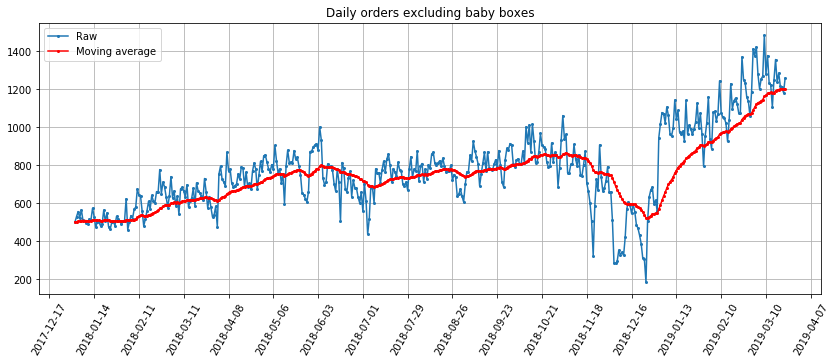

In [37]:
fig, ax1 = plt.subplots(figsize=(14, 5))
p1 = ax1.plot(daily_orders.index, daily_orders["count"], marker='o', markersize=2)
p2 = ax1.plot(daily_orders.index, daily_orders["ma_count"], marker='o', markersize=2, color='red')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(28))
plt.xticks(rotation=60)
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.grid(which="major")
ax1.yaxis.grid(which="major")
ax1.set_title("Daily orders excluding baby boxes")
ax1.legend((p1[0], p2[0]), ('Raw', 'Moving average'))

In [8]:
order_placed_bb = order_placed[order_placed["order_type"] == "hello_baby_box"]
daily_orders_bb = order_placed_bb[["created_date", "state"]].groupby(["created_date"]).count()
daily_orders_bb.rename({"state": "count"}, axis="columns", inplace=True)

prev_val = daily_orders_bb.loc[daily_orders_bb.index[0], "count"]
ma_count = []
for i in daily_orders_bb.index:
    ave = daily_orders_bb.loc[i,"count"]*.05 + prev_val*.95
    ma_count.append(ave)
    prev_val = ave

daily_orders_bb["ma_count"] = ma_count

## Daily Baby Box Orders

This plot shows daily Baby Box orders.  We see roughly 600 boxes/day for the first five months of 2018, then a drop at the beginning of June to 350/day.  Orders are steady until the beginning of 2019, where they go back up to 600/day.

We notice three exceptional days near the end of 2018 that are large enough to destabilize the moving average.  These days are:

* 10/8/18 - 3016 boxes
* 11/15/18 - 4899 boxes
* 12/14/18 - 8368 boxes

The days immediately before and after are unremarkable.

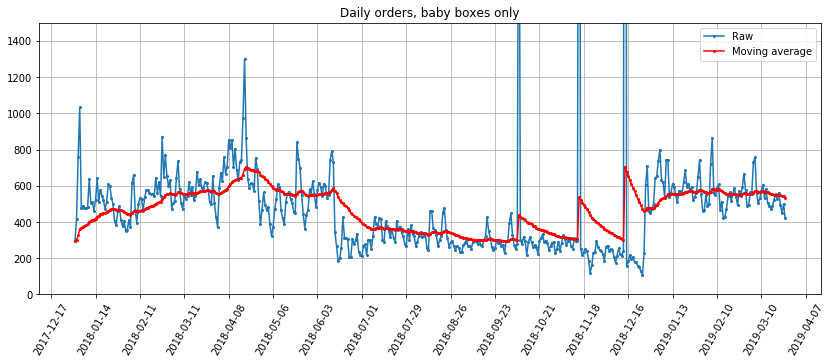

In [9]:
fig, ax1 = plt.subplots(figsize=(14, 5))
p1 = ax1.plot(daily_orders_bb.index, daily_orders_bb["count"], marker='o', markersize=2)
p2 = ax1.plot(daily_orders_bb.index, daily_orders_bb["ma_count"], marker='o', markersize=2, color='red')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(28))
plt.xticks(rotation=60)
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.grid(which="major")
ax1.yaxis.grid(which="major")
ax1.set_ylim(bottom=0, top=1500)
ax1.set_title("Daily orders, baby boxes only")
ax1.legend((p1[0], p2[0]), ('Raw', 'Moving average'))

In [10]:
ol1 = daily_orders_bb.loc[datetime.date(2018,10,8), "count"]
ol2 = daily_orders_bb.loc[datetime.date(2018,11,15), "count"]
ol3 = daily_orders_bb.loc[datetime.date(2018,12,14), "count"]
print("Baby box orders on 10/8/18: " + str(ol1))
print("Baby box orders on 11/15/18: " + str(ol2))
print("Baby box orders on 12/14/18: " + str(ol3))

Baby box orders on 10/8/18: 3016
Baby box orders on 11/15/18: 4899
Baby box orders on 12/14/18: 8368


In [11]:
daily_orders["weekday"] = pd.Series(daily_orders.index).apply(lambda x: x.weekday()).to_list()
ave_per_weekday = daily_orders.groupby("weekday").mean()[["count"]]
ave_per_weekday.rename({"count": "ave"}, axis = "columns", inplace = True)
std_per_weekday = daily_orders.groupby("weekday").std()[["count"]]
std_per_weekday.rename({"count": "std"}, axis = "columns", inplace = True)
count_per_weekday = daily_orders.groupby("weekday").count()[["count"]]
weekday = pd.concat([count_per_weekday, ave_per_weekday, std_per_weekday], axis=1)
weekday.index = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday["se"] = weekday["std"] / np.sqrt(weekday["count"])

## Short Term Volatility - Days of the Week

I wanted to investigate if any of the short term volatility was due to the day of the week.  I calculated the average number of orders (excluding Baby Boxes) per weekday as well as the standard error of these means.  I've plotted each average below with +/- 2\*SE error bars.  Saturday and Monday were the busiest days and Wednesday and Thursday were the quietest.  However, the largest lower end of any interval was just under 775 orders and the smallest upper end was just over 787 orders.  This means that every error range contained the interval from 775 to 787 and that no day was statistically significant from any other at a 95% confidence level.

(300, 1100)

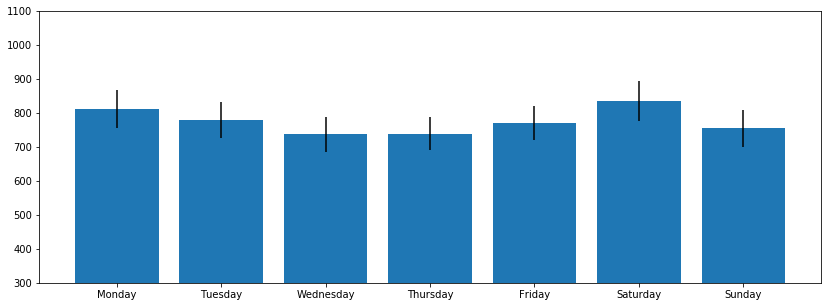

In [12]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(weekday.index, height = weekday["ave"], yerr = 2*weekday["se"])
ax.set_ylim(300,1100)

In [13]:
weekday["lower"] = weekday["ave"] - 2*weekday["se"]
weekday["upper"] = weekday["ave"] + 2*weekday["se"]
print("Largest lower limit: " + str(np.max(weekday["lower"])))
print("Smallest upper limit: " + str(np.min(weekday["upper"])))

Largest lower limit: 774.944609281988
Smallest upper limit: 787.0948185333368


In [14]:
############

In [15]:
order_placed["year"] = order_placed["created_at"].dt.year
order_placed["month"] = order_placed["created_at"].dt.month
order_types = order_placed[["order_type","year","month","state"]].groupby(["order_type","year","month"]).count()
types = np.unique(order_types.index.get_level_values(0))
type_totals = pd.DataFrame(index=order_types.loc["inventory",:].index)
for ty in types:
    data_piece = order_types.loc[ty,:]
    data_piece.rename({"state":ty},axis="columns",inplace=True)
    type_totals = type_totals.join(data_piece, how="left")

type_totals.fillna(0, inplace=True)
gc_orders = order_items[order_items["name"].str.match("Babylist Store Gift Card.*")]
gc_orders["year"] = gc_orders["created_at"].dt.year
gc_orders["month"] = gc_orders["created_at"].dt.month
gc_orders = gc_orders[gc_orders["order_id"].isin(list(order_placed.index))]
gc_orders = gc_orders[["year","month","id"]].groupby(["year","month"]).count()
type_totals.iloc[-4:,2] = gc_orders.iloc[-4:,0]

type_share = pd.DataFrame(index=type_totals.index,
                          data=type_totals.values/type_totals.apply(sum,axis=1).values.reshape(len(type_totals),1),
                          columns=type_totals.columns)

## Orders by Type

I wanted to see if the if there was any pattern to the type of orders placed.  We can see that the largest share of orders comes from inventory, where it was just below 40% in Jan-18 and has increased to over 50% in Mar-19.  Most of this gain in share came from Baby Boxes.  We can see a sharp drop in Dec-18 followed by a quick recovery, which is consistent with what was seen above.

Electronic gift cards accounted for about 10% or sales in Jan-18 and have stayed roughly at that level.  Note that starting in Dec-18 orders stopped being classified at gift card.  I estimated values for the last four months by counting orders of type inventory that contained an item with "Gift Card" in its name.

Text(0.5, 1.0, 'Share of orders by type')

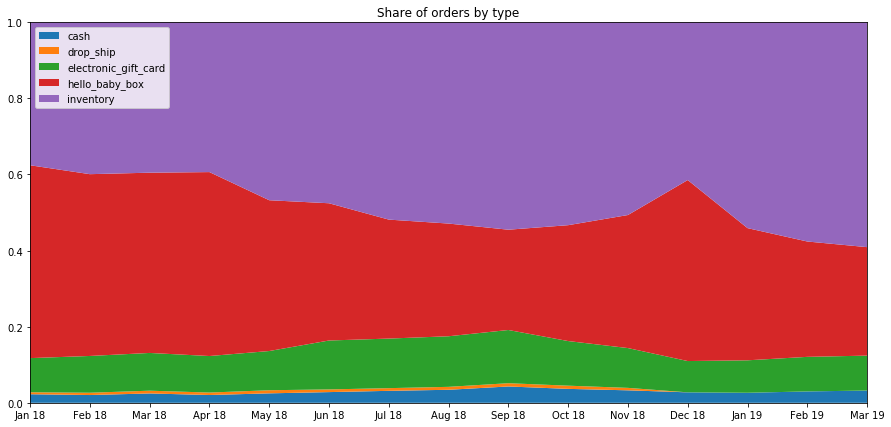

In [16]:
fig, ax = plt.subplots(figsize=(15, 7))
x_labs = ["Jan 18", "Feb 18", "Mar 18", "Apr 18", "May 18", "Jun 18", "Jul 18", "Aug 18",
          "Sep 18", "Oct 18", "Nov 18", "Dec 18", "Jan 19", "Feb 19", "Mar 19"]
ax.stackplot(x_labs, type_share.loc[:,types[0]], type_share.loc[:,types[1]],
             type_share.loc[:,types[2]], type_share.loc[:,types[3]],
             type_share.loc[:,types[4]], labels=list(types))
ax.legend(loc='upper left')
ax.margins(0,0)
ax.set_title("Share of orders by type")

In [17]:
oi_placed = order_items[order_items["order_id"].isin(list(order_placed_nobb.index))]
oi_placed["year"] = oi_placed["created_at"].dt.year
oi_placed["month"] = oi_placed["created_at"].dt.month
oi_placed = oi_placed[~oi_placed["name"].str.match("Babylist Store Gift Card.*")]

top_items_oct = oi_placed[oi_placed["month"] == 10]
top_items_oct = top_items_oct[["name","id"]].groupby(["name"]).count().sort_values("id",ascending=False)
top_items_oct.rename({"id":"count"},axis="columns",inplace=True)

top_items_nov = oi_placed[oi_placed["month"] == 11]
top_items_nov = top_items_nov[["name","id"]].groupby(["name"]).count().sort_values("id",ascending=False)
top_items_nov.rename({"id":"count"},axis="columns",inplace=True)

top_items_dec = oi_placed[oi_placed["month"] == 12]
top_items_dec = top_items_dec[["name","id"]].groupby(["name"]).count().sort_values("id",ascending=False)
top_items_dec.rename({"id":"count"},axis="columns",inplace=True)

top_items_jan = oi_placed[oi_placed["month"] == 1]
top_items_jan = top_items_jan[top_items_jan["year"] == 2019]
top_items_jan = top_items_jan[["name","id"]].groupby(["name"]).count().sort_values("id",ascending=False)
top_items_jan.rename({"id":"count"},axis="columns",inplace=True)

top_items = list(top_items_oct.index[0:10]) + list(top_items_nov.index[0:10]) + \
            list(top_items_dec.index[0:10]) + list(top_items_jan.index[0:10])
top_items = np.unique(top_items)
top_items_df = pd.DataFrame(index=top_items)
top_items_df = top_items_df.join(top_items_oct, how="inner", rsuffix="gg")
top_items_df = top_items_df.join(top_items_nov, how="inner", rsuffix="gg")
top_items_df = top_items_df.join(top_items_dec, how="inner", rsuffix="gg")
top_items_df = top_items_df.join(top_items_jan, how="inner", rsuffix="gg")
top_items_df.columns = ["Oct","Nov","Dec","Jan"]
top_items_df["nov_change_%"] = np.round(100*(top_items_df["Nov"]-top_items_df["Oct"])/top_items_df["Oct"],1)
top_items_df["dec_change_%"] = np.round(100*(top_items_df["Dec"]-top_items_df["Nov"])/top_items_df["Nov"],1)
top_items_df["jan_change_%"] = np.round(100*(top_items_df["Jan"]-top_items_df["Dec"])/top_items_df["Dec"],1)

## Orders of Popular Items

I wanted to examine the cause of the decline and subsequent recovery in sales from Oct-18 through Jan-19.  I looked at each of the top ten items by number of orders (filtering out Baby Boxes and gift cards) and tabulated the number of orders for each item during the time period of interest.  Note that there are 14 items rather than 40 as the top selling items are mostly the same from month to month.

Most items follow the expected pattern: a large drop in October, November, or both, then a strong recovery in January.  Some of the only exceptions are the OXO bottle brush, which goes up in both November and December and then is slightly down in January, and the Britax car mirror, which goes way down in November, then up in December, then down again in January.

For further investigation at the item level, it would be good to have some way to group individual items into categories.  This would make it easier to see if certain types of items or particular brands were trending one way or another.

In [18]:
top_items_df.sort_values("Jan",ascending=False)

,Oct,Nov,Dec,Jan,nov_change_%,dec_change_%,jan_change_%
Hatch Baby Rest Night Light and Sound Machine,837,660,435,1057,-21.1,-34.1,143.0
Babylist Bottle Box,600,339,387,823,-43.5,14.2,112.7
Lovevery The Play Gym,271,290,230,454,7.0,-20.7,97.4
Ubbi Steel Diaper Pail - White,266,245,174,414,-7.9,-29.0,137.9
FridaBaby NoseFrida The Snotsucker Nasal Aspirator,293,283,170,354,-3.4,-39.9,108.2
Summer Infant 2-Sided Changing Pad,193,305,206,352,58.0,-32.5,70.9
"Solly Baby Babylist + Solly Baby Collaboration Wrap - Black & Natural Stripe, Original Length",231,210,162,321,-9.1,-22.9,98.1
Vulli Sophie the Giraffe Teether,203,234,123,294,15.3,-47.4,139.0
Boon Lawn Countertop Drying Rack - Green,243,219,145,273,-9.9,-33.8,88.3
Boppy Bare Naked Nursing Pillow and Positioner,209,211,96,270,1.0,-54.5,181.2


In [19]:
############

In [20]:
bottles = order_items[order_items["name"].str.match(".*bottle.*", case=False)]
bottles = bottles[~bottles["name"].str.match(".*steriliz.*", case=False)]
bottles = bottles[~bottles["name"].str.match(".*mixer.*", case=False)]
bottles = bottles[~bottles["name"].str.match(".*brush.*", case=False)]
bottles = bottles[~bottles["name"].str.match(".*warmer.*", case=False)]
bottles = bottles[~bottles["name"].str.match(".*washer.*", case=False)]
bottles = bottles[~bottles["name"].str.match(".*fund.*", case=False)]
bottles = bottles[~bottles["name"].str.match(".*cooler.*", case=False)]
bottles = bottles[~bottles["name"].str.match(".*cleaning.*", case=False)]
bottles = bottles[~bottles["name"].str.match(".*sealing discs.*", case=False)]
bottles = bottles[~bottles["name"].str.match(".*bottle bag.*", case=False)]
bottles = bottles[~bottles["name"].str.match(".*drying rack.*", case=False)]
bottles = bottles[bottles["order_id"].isin(order_placed.index.to_list())]
bottles["month"] = bottles["created_at"].dt.month
bottles["year"] = bottles["created_at"].dt.year

In [21]:
bottles_sum = bottles[["year","month","price"]].groupby(["year","month"]).sum()
bottles_sum.rename({"price":"sum"},axis="columns",inplace=True)
bottles_count = bottles[["year","month","price"]].groupby(["year","month"]).count()
bottles_count.rename({"price":"count"},axis="columns",inplace=True)
bottles_group = pd.concat([bottles_sum, bottles_count], axis=1)

not_bottles = order_items[~order_items["id"].isin(bottles["id"].to_list())]
not_bottles = not_bottles[not_bottles["order_id"].isin(order_placed.index.to_list())]
not_bottles["month"] = not_bottles["created_at"].dt.month
not_bottles["year"] = not_bottles["created_at"].dt.year

not_bottles_sum = not_bottles[["year","month","price"]].groupby(["year","month"]).sum()
not_bottles_sum.rename({"price":"sum"},axis="columns",inplace=True)
not_bottles_count = not_bottles[["year","month","price"]].groupby(["year","month"]).count()
not_bottles_count.rename({"price":"count"},axis="columns",inplace=True)
not_bottles_group = pd.concat([not_bottles_sum, not_bottles_count], axis=1)

all_bott = pd.concat([bottles_group, not_bottles_group],axis=1)
all_bott.columns = ["sum_bottle", "count_bottle", "sum_not_bottle", "count_not_bottle"]
all_bott["bott_share"] = all_bott["sum_bottle"] / (all_bott["sum_not_bottle"] + all_bott["sum_not_bottle"])

## Bottles Overview

To examine orders of bottles, I first needed to identify items that were bottles.  I took every item in order_items that had bottle in the name, then I went through the list and manually added filters to eliminate "bottle adjacent" non-bottle items.

Below, I plot the number of bottle orders per month and the percent of total orders that bottles account for.  We can see that the number of bottles per month rose from about 15,000 in January 2018 to over 50,000 in March 2019.  The dropoff in December is not as pronounced when we looked at all items, and the increase in January is almost double that of mid-2018 levels.  Compare this to the roughly 50% increase on all orders (800/day to 1200/day as seen above).

This is reflected in the increasing order share of bottles.  In Jan-2018, bottles are only half a percent of all items ordered and by Mar-2019 they represent 1%.

Text(0.5, 1.0, 'Monthly total revenue and % of total revenue, bottles')

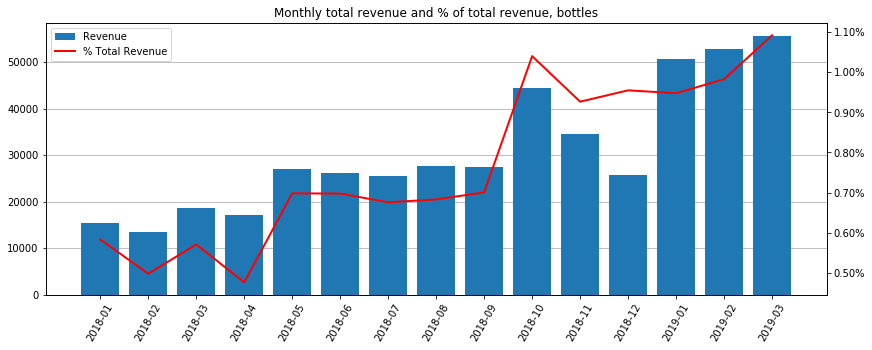

In [22]:
labels = []
for i in bottles_group.index:
    y = i[0]
    m = i[1]
    if m < 10:
        labels.append(str(i[0]) + "-0" + str(i[1]))
    else:
        labels.append(str(i[0]) + "-" + str(i[1]))

fig, ax1 = plt.subplots(figsize=(14, 5))
p1 = ax1.bar(labels, bottles_group["sum"], zorder=2)
ax1.yaxis.grid(which="major", zorder=0)
plt.xticks(rotation=60)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
p2 = ax2.plot(all_bott["bott_share"].to_list(), zorder=3, color="red", linewidth=2.0)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax1.legend((p1[0], p2[0]), ('Revenue', '% Total Revenue'))
ax1.set_title("Monthly total revenue and % of total revenue, bottles")

In [23]:
bottles_count = bottles[["name", "price"]].groupby("name").count()
bottles_count.rename({"price": "count"}, axis="columns", inplace="True")
bottles_min = bottles[["name", "price"]].groupby("name").min()
bottles_min.rename({"price": "min_price"}, axis="columns", inplace="True")
bottles_max = bottles[["name", "price"]].groupby("name").max()
bottles_max.rename({"price": "max_price"}, axis="columns", inplace="True")
bottles_ave = bottles[["name", "price"]].groupby("name").mean()
bottles_ave.rename({"price": "ave_price"}, axis="columns", inplace="True")
bottles_sum = bottles[["name", "price"]].groupby("name").sum()
bottles_sum.rename({"price": "sum"}, axis="columns", inplace="True")

bottles_item = pd.concat([bottles_count, bottles_min, bottles_max, bottles_ave, bottles_sum], axis = 1)
bottles_item.sort_values("sum", ascending=False, inplace=True)

## Most Commonly Ordered Bottles

Below, I've tabulated the 10 most ordered bottles.  We can see the total number of orders, minimum price, maximum price, average price, and total revenue.  One thing I found interesting is the max price for some items is much higher than the average and minimum prices.  Take for example the "Comotomo Baby Bottle (2 Pack) - Pink, 8 oz".  It typically sells for \\$20-25, however we can see that there was one completed order where it sold for \\$95.96 and three more where it sold for \\$71.97.

In [24]:
bottles_item.head(n=10)

,count,min_price,max_price,ave_price,sum
name,,,,,
Babylist Bottle Box,3893,10.00,74.97,25.484279,99210.30
"Comotomo Baby Bottle (2 Pack) - Green, 8 oz",1668,21.27,95.96,24.177680,40328.37
"Comotomo Baby Bottle (2 Pack) - Green, 5 oz",1671,12.75,91.96,23.804907,39778.00
Dr. Brown's Natural Flow Newborn Bottle Gift Set,1431,17.95,19.95,19.722061,28222.27
Dr. Brown's Natural Flow Original Newborn Bottle Gift Set,1323,17.93,99.75,21.082260,27891.83
Philips Avent Natural Bottle Newborn Starter Gift Set,477,43.19,143.97,48.000021,22896.01
"Comotomo Baby Bottle (2 Pack) - Pink, 5 oz",860,20.69,45.98,23.339209,20071.72
"Comotomo Baby Bottle (2 Pack) - Pink, 8 oz",694,21.59,95.96,25.161715,17462.23
Dr. Brown's Options Glass Bottle Starter Set,286,53.99,59.99,59.129860,16911.14


In [25]:
bottles[bottles["name"] == "Comotomo Baby Bottle (2 Pack) - Pink, 8 oz"].sort_values("price", ascending=False).head()

,id,order_id,name,price,product_id,created_at,month,year
577030,856652,620644,"Comotomo Baby Bottle (2 Pack) - Pink, 8 oz",95.96,15528.0,2018-12-01 22:10:14,12,2018
771393,1081563,767024,"Comotomo Baby Bottle (2 Pack) - Pink, 8 oz",71.97,15528.0,2019-03-09 22:26:07,3,2019
746517,1042215,740556,"Comotomo Baby Bottle (2 Pack) - Pink, 8 oz",71.97,15528.0,2019-02-23 20:46:45,2,2019
742478,1025918,729625,"Comotomo Baby Bottle (2 Pack) - Pink, 8 oz",71.97,15528.0,2019-02-17 16:25:31,2,2019
692024,1000073,711791,"Comotomo Baby Bottle (2 Pack) - Pink, 8 oz",47.98,15528.0,2019-02-06 20:39:14,2,2019


## Items Most Commomnly Ordered with Bottles

I took all orders containing bottles, then looked at which items were included in these orders that weren't bottles.  The table below contains the top fifteen items that appeared most often in orders with bottles.

In [26]:
order_bottles = order_items[order_items["order_id"].isin(bottles["order_id"].to_list())]
order_bottles_oi = order_bottles[~order_bottles["name"].isin(list(bottles_item.index))]
outp = order_bottles_oi[["name","price"]].groupby("name").count().sort_values("price", ascending=False).head(n=15)
outp.rename({"price":"count"},axis="columns")

,count
name,
Dr. Brown's Bottle Brush - Blue,522
Philips Avent Soothie Pacifier (2 Pack) - Green,501
Boon Lawn Countertop Drying Rack - Green,429
Boon Drying Rack Accessory (Twig) - White,403
FridaBaby NoseFrida The Snotsucker Nasal Aspirator,379
Boon Grass Countertop Drying Rack - Green,352
Britax Back Seat Mirror - Silver,324
Munchkin Deluxe Dishwasher Basket - Assorted--Colors Vary,305
Munchkin Waterproof Changing Pad Liners (3-Pack),265


In [27]:
##########

In [28]:
order_placed["is_user"] = ~order_placed["user_id"].isna()
order_placed["month"] = order_placed["created_at"].dt.month
order_placed["year"] = order_placed["created_at"].dt.year
order_placed_nobb = order_placed[order_placed["order_type"] != "hello_baby_box"]
order_placed_bb = order_placed[order_placed["order_type"] == "hello_baby_box"]
user_group_bb = order_placed_bb[["year", "month", "state"]].groupby(["year", "month"]).count()
user_group_nobb = order_placed_nobb[["year","month","is_user","state"]].groupby(["is_user","year","month"]).count()

## Users vs. Non-users

The graph below shows monthly orders of users and non-users.  The user orders are separated into sales and Baby Boxes (you must be a user to order a Baby Box).  Orders from users have risen steadily from about 2,000/month in Jan-18 to over 5,000/month in Mar-19.

Non-user orders follow the general pattern that we saw in daily orders: a steady increase in early 2018, a plateau in the middle of the year, a sharp drop in November and December, then a big recovery in January.

Finally, we notice that the number of Baby Boxes ordered is several times that of sales orders from users.  Also, there doesn't appear to be a strong relationship between number of Baby Boxes ordered and user sales orders.

(array([ 0.2,  1.2,  2.2,  3.2,  4.2,  5.2,  6.2,  7.2,  8.2,  9.2, 10.2,
        11.2, 12.2, 13.2, 14.2]), <a list of 15 Text xticklabel objects>)

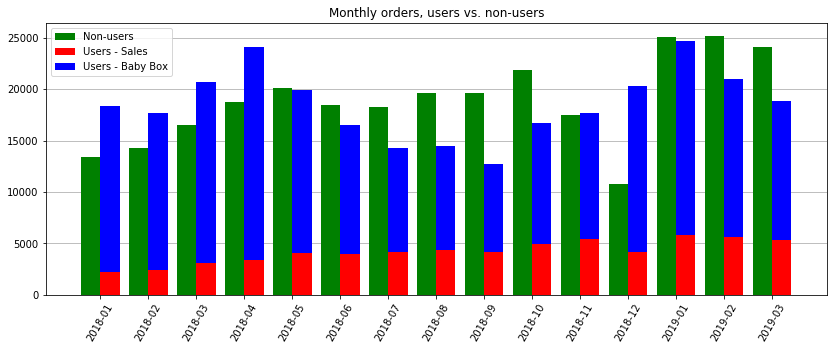

In [29]:
labels = ["2018-01", "2018-02", "2018-03", "2018-04", "2018-05", "2018-06", "2018-07", "2018-08",
          "2018-09", "2018-10", "2018-11", "2018-12", "2019-01", "2019-02", "2019-03"]

ind = np.arange(len(labels))
width = .4
fig, ax = plt.subplots(figsize=(14, 5))
ax.yaxis.grid(which="major", zorder=0)
p1 = ax.bar(ind, user_group_nobb.loc[False,:]["state"], width, zorder=3, color="green")
p2 = ax.bar(ind+width, user_group_nobb.loc[True,:]["state"], width, zorder=3, color="red")
p3 = ax.bar(ind+width,user_group_bb["state"],width, bottom=user_group_nobb.loc[True,:]["state"],zorder=3,color="blue")
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)
ax.set_title("Monthly orders, users vs. non-users")
ax.legend((p1[0], p2[0], p3[0]), ("Non-users", "Users - Sales", "Users - Baby Box"))
plt.xticks(rotation=60)

## Share of Sales Orders Coming From Users

The plot below shows the percentage of sales orders (no Baby Boxes) coming from users.  As a general trend, we see around 14% in early 2018 rising steadily to 18% in Mar-19.  Share of user sales spikes to 24% in Nov-18 and 28% in Dec-18.  We can see from the graph above that this is mostly due to depressed sales from non-users.  As user sales were mostly steady during these months, the proportion relative to the total rose.

Text(0.5, 1.0, 'Proportion of sales orders coming from users')

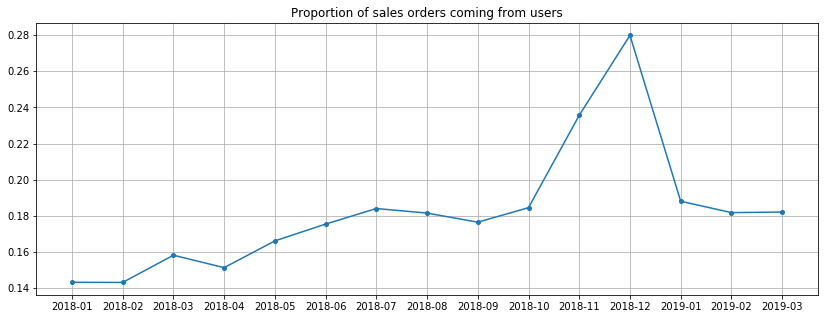

In [30]:
user_orders = np.array(user_group_nobb.loc[True,:]["state"])
nonuser_orders = np.array(user_group_nobb.loc[False,:]["state"])
user_share = pd.DataFrame(index=user_group_nobb.loc[False,:].index,
                          data={"prop_users": user_orders / (nonuser_orders + user_orders)})

plot_ob = pd.Series(index=labels,data=user_share["prop_users"].to_list())
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(plot_ob, marker='o', markersize=4)
ax.yaxis.grid(which="major")
ax.xaxis.grid(which="major")
ax.set_title("Proportion of sales orders coming from users")